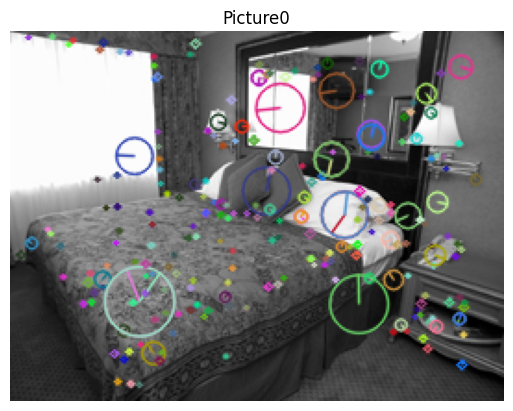

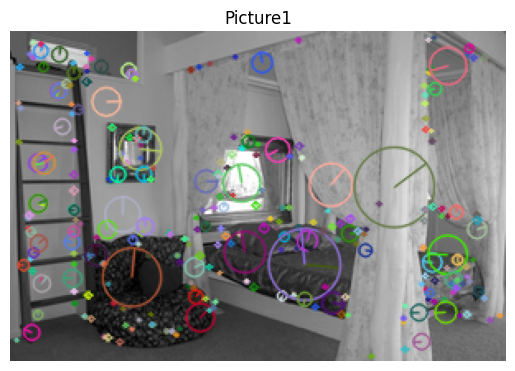

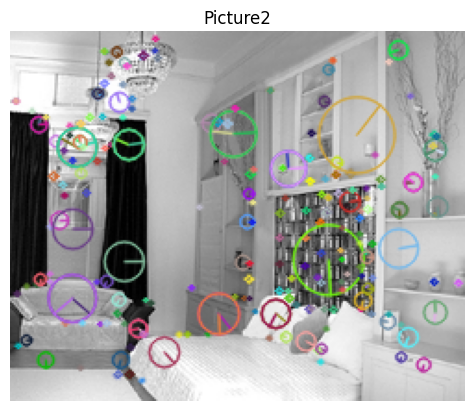

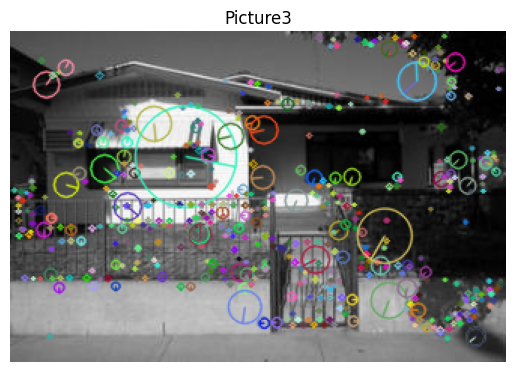

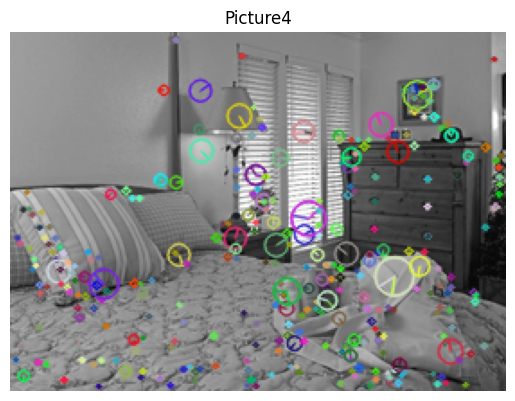

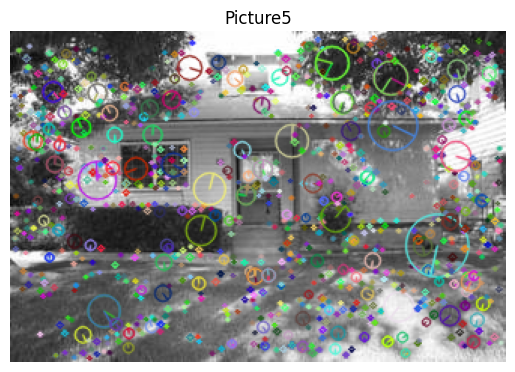

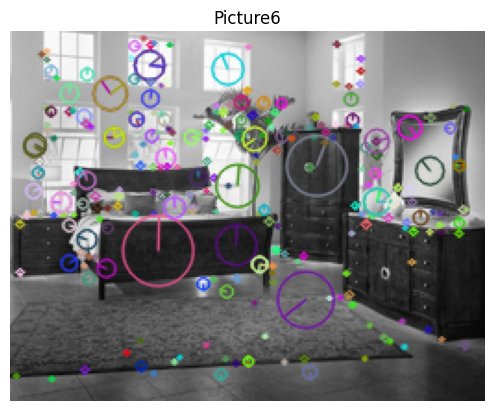

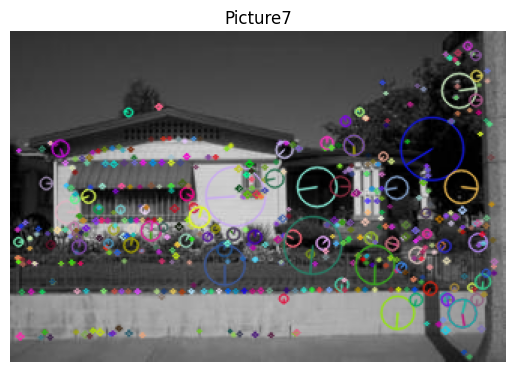

              precision    recall  f1-score   support

          00       1.00      1.00      1.00         1
          01       1.00      1.00      1.00         3

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



In [5]:
import cv2
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt


def load_images_from_folder(folder):  
    images = []
    labels = []
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for image_filename in os.listdir(path):
                img = cv2.imread(
                    os.path.join(path, image_filename), cv2.IMREAD_GRAYSCALE
                )
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels


folder = "data/15-Scene"
test_folder = "test_img"
images, labels = load_images_from_folder(test_folder)
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.3, random_state=42
)


def extract_sift_features(X):
    sift = cv2.SIFT_create()
    keypoints = []
    descriptors = []
    for img in X:
        kp, des = sift.detectAndCompute(img, None)
        keypoints.append(kp)
        descriptors.append(des)
    return descriptors, keypoints


def show_features_in_img(X, keypoints):
    for i, (img, kp) in enumerate(zip(X, keypoints)):
        # 绘制关键点
        img_with_keypoints = cv2.drawKeypoints(
            img, kp, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
        )

        # 使用matplotlib显示图
        plt.imshow(img_with_keypoints)
        plt.title(f"Picture{i}")
        plt.axis("off") 
        plt.show()


train_descriptors, train_keypoints = extract_sift_features(X_train)
test_descriptors, test_keypoints = extract_sift_features(X_test)

show_features_in_img(X_train, train_keypoints)

def build_vocabulary(descriptors_list, k):
    all_descriptors = np.vstack(descriptors_list)
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(all_descriptors)
    return kmeans


k = 100  # 根据需要调整K值
vocab_model = build_vocabulary(train_descriptors, k)


def features_to_histogram(features, vocab_model):
    histogram = np.zeros(len(vocab_model.cluster_centers_))
    words = vocab_model.predict(features)
    for w in words:
        histogram[w] += 1
    return histogram


def prepare_histograms(descriptors_list, vocab_model):
    histograms = []
    for descriptors in descriptors_list:
        if descriptors is not None:
            histogram = features_to_histogram(descriptors, vocab_model)
            histograms.append(histogram)
        else:
            histograms.append(None)
    return histograms


train_histograms = prepare_histograms(train_descriptors, vocab_model)
test_histograms = prepare_histograms(test_descriptors, vocab_model)


# 处理可能的None值
train_histograms = [
    hist if hist is not None else np.zeros(k) for hist in train_histograms
]
test_histograms = [
    hist if hist is not None else np.zeros(k) for hist in test_histograms
]

# SVM训练
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

clf = SVC(kernel="linear")  # 可以尝试其他核
clf.fit(train_histograms, y_train_encoded)


predictions = clf.predict(test_histograms)
print(classification_report(y_test_encoded, predictions, target_names=le.classes_))